# Bibliotecas

In [83]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Habilitando leitura com a WebCan, mostrando imagem tirada e redimensionando

In [84]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture Photo';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [85]:
Image_file = take_photo()

<IPython.core.display.Javascript object>

400 300


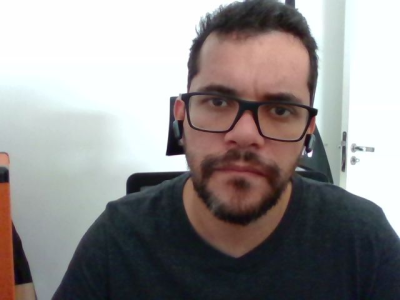

In [86]:
image = cv2.imread(Image_file)

image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w, h)
cv2_imshow(image)

# Trazendo modelo treinado

In [87]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2025-08-30 14:11:37--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.001s  

Last-modified header missing -- time-stamps turned off.
2025-08-30 14:11:37 (19.5 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2025-08-30 14:11:37--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

# Configurando caixa de leitura, marcação e reconhecimento

In [88]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

[INFO] loading model...


In [89]:
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

In [90]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


In [91]:
for i in range(0, detections.shape[2]):

	confidence = detections[0, 0, i, 2]

	if confidence > 0.5:
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

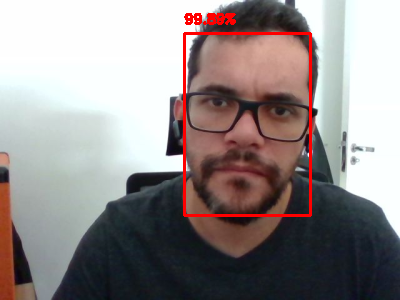

In [92]:
cv2_imshow(image)